In [38]:
from packages import *
import numpy as np, matplotlib.pyplot as plt, matplotlib.patches as patches, matplotlib.cm as cm
import random
from PIL import Image 
from collections import Counter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Acquisition
In this notebook, we will explore the different annotation files provided in the [DeepFashion](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html "Lab webpage") dataset. Then we will construct dictionaries and lists that will make it easier to link the images with their appropriate labels.

## Goals:
* understand the annotation files.
* link labels and images through dictionaries.
* explore how the data is distributed.

In [2]:
# defaults for matplotlib plots
plt.rcParams['figure.figsize'] = def_size = [6.0, 6.0]
plt.rcParams['font.size'] = def_font = 15.0

In [54]:
annot_files = [i for i in os.listdir(ANNOT_DIR) if i[0] != '.' and 'list' in i]
annot_files

FileNotFoundError: [Errno 2] No such file or directory: '/media/Projects/pennyworth/src/../data/annotations'

## Linking
Different labels of the dataset are provided in different text files. By creating dictionaries that link these labels to their respective images will help us further along when we are constructing the dataset to be used in training.

### Categories

In [4]:
cat_types_str = {1: 'upper', 2: 'lower', 3: 'full'}

In [5]:
cat = ['N/A']
cat_types = {1: [], 2: [], 3: []}
cat_types_inv = {}
with open(os.path.join(ANNOT_DIR, 'list_category_cloth.txt')) as f:
    for i, l in enumerate(f.readlines()[2:]):
        l = l.strip()
        cat_type = int(l[15:])
        c = l[:15].strip()
        cat.append(c)
        cat_types[cat_type].append(i+1)
        cat_types_inv[i+1] = cat_type
    cat = np.array(cat)

In [6]:
save_pickle(cat, os.path.join(LINK_DIR, 'cat.pkl'))
save_pickle(cat_types, os.path.join(LINK_DIR, 'cat_types.pkl'))
save_pickle(cat_types_inv, os.path.join(LINK_DIR, 'cat_types_inv.pkl'))
save_pickle(cat_types_str, os.path.join(LINK_DIR, 'cat_types_str.pkl'))

In [7]:
cat[1:11]

array(['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan',
       'Flannel', 'Halter', 'Henley', 'Hoodie'], dtype='<U11')

### Attributes

In [8]:
attr_types_str = {1:'texture',
                  2: 'fabric',
                  3: 'shape',
                  4: 'part',
                  5: 'style'}

In [9]:
attr =  []
attr_types = {1: [], 2: [], 3: [], 4: [], 5: []}
attr_types_inv = {}
with open(os.path.join(ANNOT_DIR, 'list_attr_cloth.txt')) as f:
    for i, l in enumerate(f.readlines()[2:]):
        l = l.strip()
        attr_type = int(l[29])
        a = l[:29].strip()
        attr.append(a)
        attr_types[attr_type].append(i)
        attr_types_inv[i] = attr_type
    attr = np.array(attr)

In [10]:
save_pickle(attr, os.path.join(LINK_DIR, 'attr.pkl'))
save_pickle(attr_types, os.path.join(LINK_DIR, 'attr_types.pkl'))
save_pickle(attr_types_inv, os.path.join(LINK_DIR, 'attr_types_inv.pkl'))
save_pickle(attr_types_str, os.path.join(LINK_DIR, 'attr_types_str.pkl'))

In [11]:
attr[:10]

array(['a-line', 'abstract', 'abstract chevron', 'abstract chevron print',
       'abstract diamond', 'abstract floral', 'abstract floral print',
       'abstract geo', 'abstract geo print', 'abstract paisley'],
      dtype='<U25')

### Images

In [12]:
img_cat = {}
with open(os.path.join(ANNOT_DIR, 'list_category_img.txt')) as f:
    for i in f.readlines()[2:]:
        l = i.strip()
        c = int(l[71:])
        _, folder, img_name = l[:71].strip().split('/')
        if folder not in img_cat:
            img_cat[folder] = {}
        img_cat[folder][img_name] = c

In [13]:
img_attr = {}
with open(os.path.join(ANNOT_DIR, 'list_attr_img.txt')) as f:
    for i in f.readlines()[2:]:
        l = i.strip()
        labels = np.array(l[71:].split(), dtype=np.int8)
        _, folder, img_name = l[:71].strip().split('/')
        if folder not in img_attr:
            img_attr[folder] = {}
        img_attr[folder][img_name] = labels

In [14]:
save_pickle(img_attr, os.path.join(LINK_DIR, 'img_attr.pkl'))
save_pickle(img_cat, os.path.join(LINK_DIR, 'img_cat.pkl'))

Sweater
['classic' 'classic crew' 'classic crew neck' 'crew' 'crew neck' 'polo']


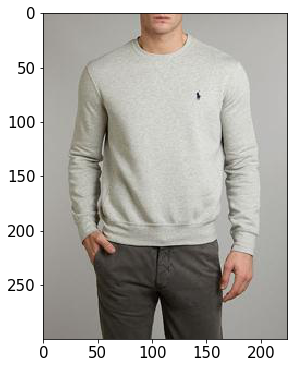

In [22]:
folder_ex = random.choice(list(img_attr.keys()))
img_name_ex = random.choice(list(img_attr[folder_ex].keys()))
img_ex = Image.open(os.path.join(IMG_DIR, folder_ex, img_name_ex))
plt.imshow(img_ex)
print(cat[img_cat[folder_ex][img_name_ex]])
print(attr[np.where(img_attr[folder_ex][img_name_ex]==1)])

### Bounding Box

In [24]:
bbox = {}
with open(os.path.join(ANNOT_DIR, 'list_bbox.txt')) as f:
    for l in f.readlines()[2:]:
        l = l.strip()
        x_1, y_1, x_2, y_2 = l[71:].split()
        _, folder, img_name = l[:71].strip().split('/')
        if folder not in bbox:
            bbox[folder] = {}
        bbox[folder][img_name] = {'x': np.array([x_1, x_2]).astype(np.int16), 
                                  'y': np.array([y_1, y_2]).astype(np.int16)}

In [17]:
save_pickle(bbox, os.path.join(LINK_DIR, 'bbox.pkl'))

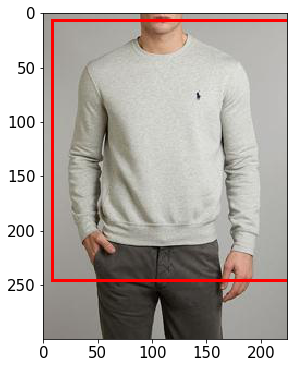

In [23]:
b = bbox[folder_ex][img_name_ex]
fig,ax = plt.subplots(1)
ax.imshow(img_ex)
box = patches.Rectangle((b['x'][0],b['y'][0]), b['x'][1]-b['x'][0],b['y'][1]-b['y'][0], 
                        linewidth=3, edgecolor='r',facecolor='none')
ax.add_patch(box)


### Landmarks

In [53]:
landmarks = {}
with open(os.path.join(ANNOT_DIR, 'list_landmarks.txt')) as f:
    lines = f.readlines()
    
#     for l in f.readlines()[2:]:
#         l = l.strip()
#         print(l[72:])
#         break
#         x_1, y_1, x_2, y_2 = l[71:].split()
#         _, folder, img_name = l[:71].strip().split('/')
#         if folder not in bbox:
#             bbox[folder] = {}
#         bbox[folder][img_name] = {'x': np.array([x_1, x_2]).astype(np.int16), 
#                                   'y': np.array([y_1, y_2]).astype(np.int16)}

## Data distribution
Now that we have linked the data, let's see how the data is distributed w.r.t. the different attributes and categories.

### Type of Clothing
Let's first look at how the type of clothing is distributed. This can be in the form of upper, lower, full clothing as well as different categories of clothing, e.g. parka, tee. 

In [46]:
cat_dist = [0] * (len(cat))
cat_types_dist = [0] * 4
for folder in img_cat:
    for img_name in img_cat[folder]:
        c = img_cat[folder][img_name]
        cat_dist[c] += 1
        cat_types_dist[cat_types_inv[c]] += 1

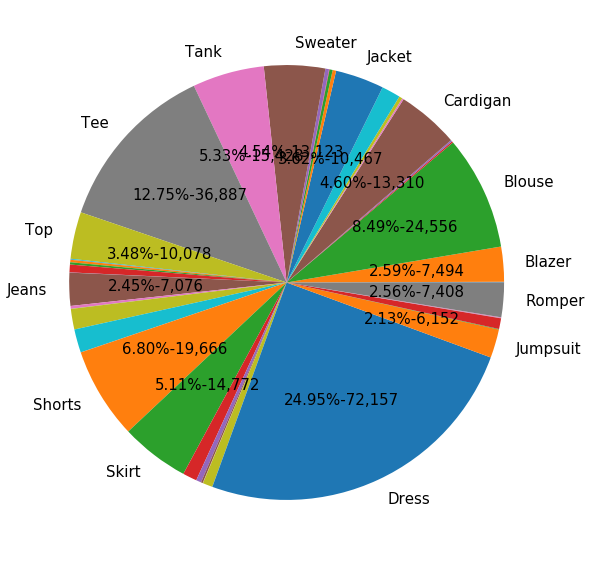

In [47]:
plt.rcParams["figure.figsize"] = [10.0, 10.0]
plt.pie(cat_dist[1:], labels=make_labels(cat_dist[1:], cat[1:], 2), autopct=make_autopct(cat_dist, 2))
plt.rcParams["figure.figsize"] = [6.0, 6.0]

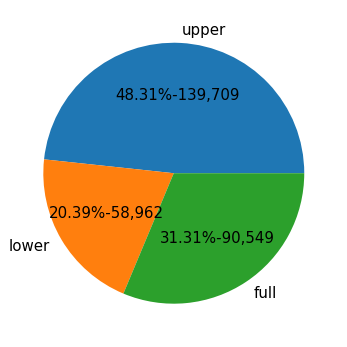

In [48]:
_ = plt.pie(cat_types_dist[1:], labels=cat_types_str.values(), autopct=make_autopct(cat_dist, 2))

### Attributes
Now, let's change our focus to the various attributes we have.

In [50]:
attr_dist = np.zeros(len(attr), dtype=np.int)
for folder in img_cat:
    for img_name in img_cat[folder]:
        a = img_attr[folder][img_name]
        attr_dist += (a == 1).astype(np.int8)

In [51]:
attr_types_dist = [0] * 6
for i in range(len(attr_dist)):
    count = attr_dist[i]
    attr_types_dist[attr_types_inv[i]]+=count

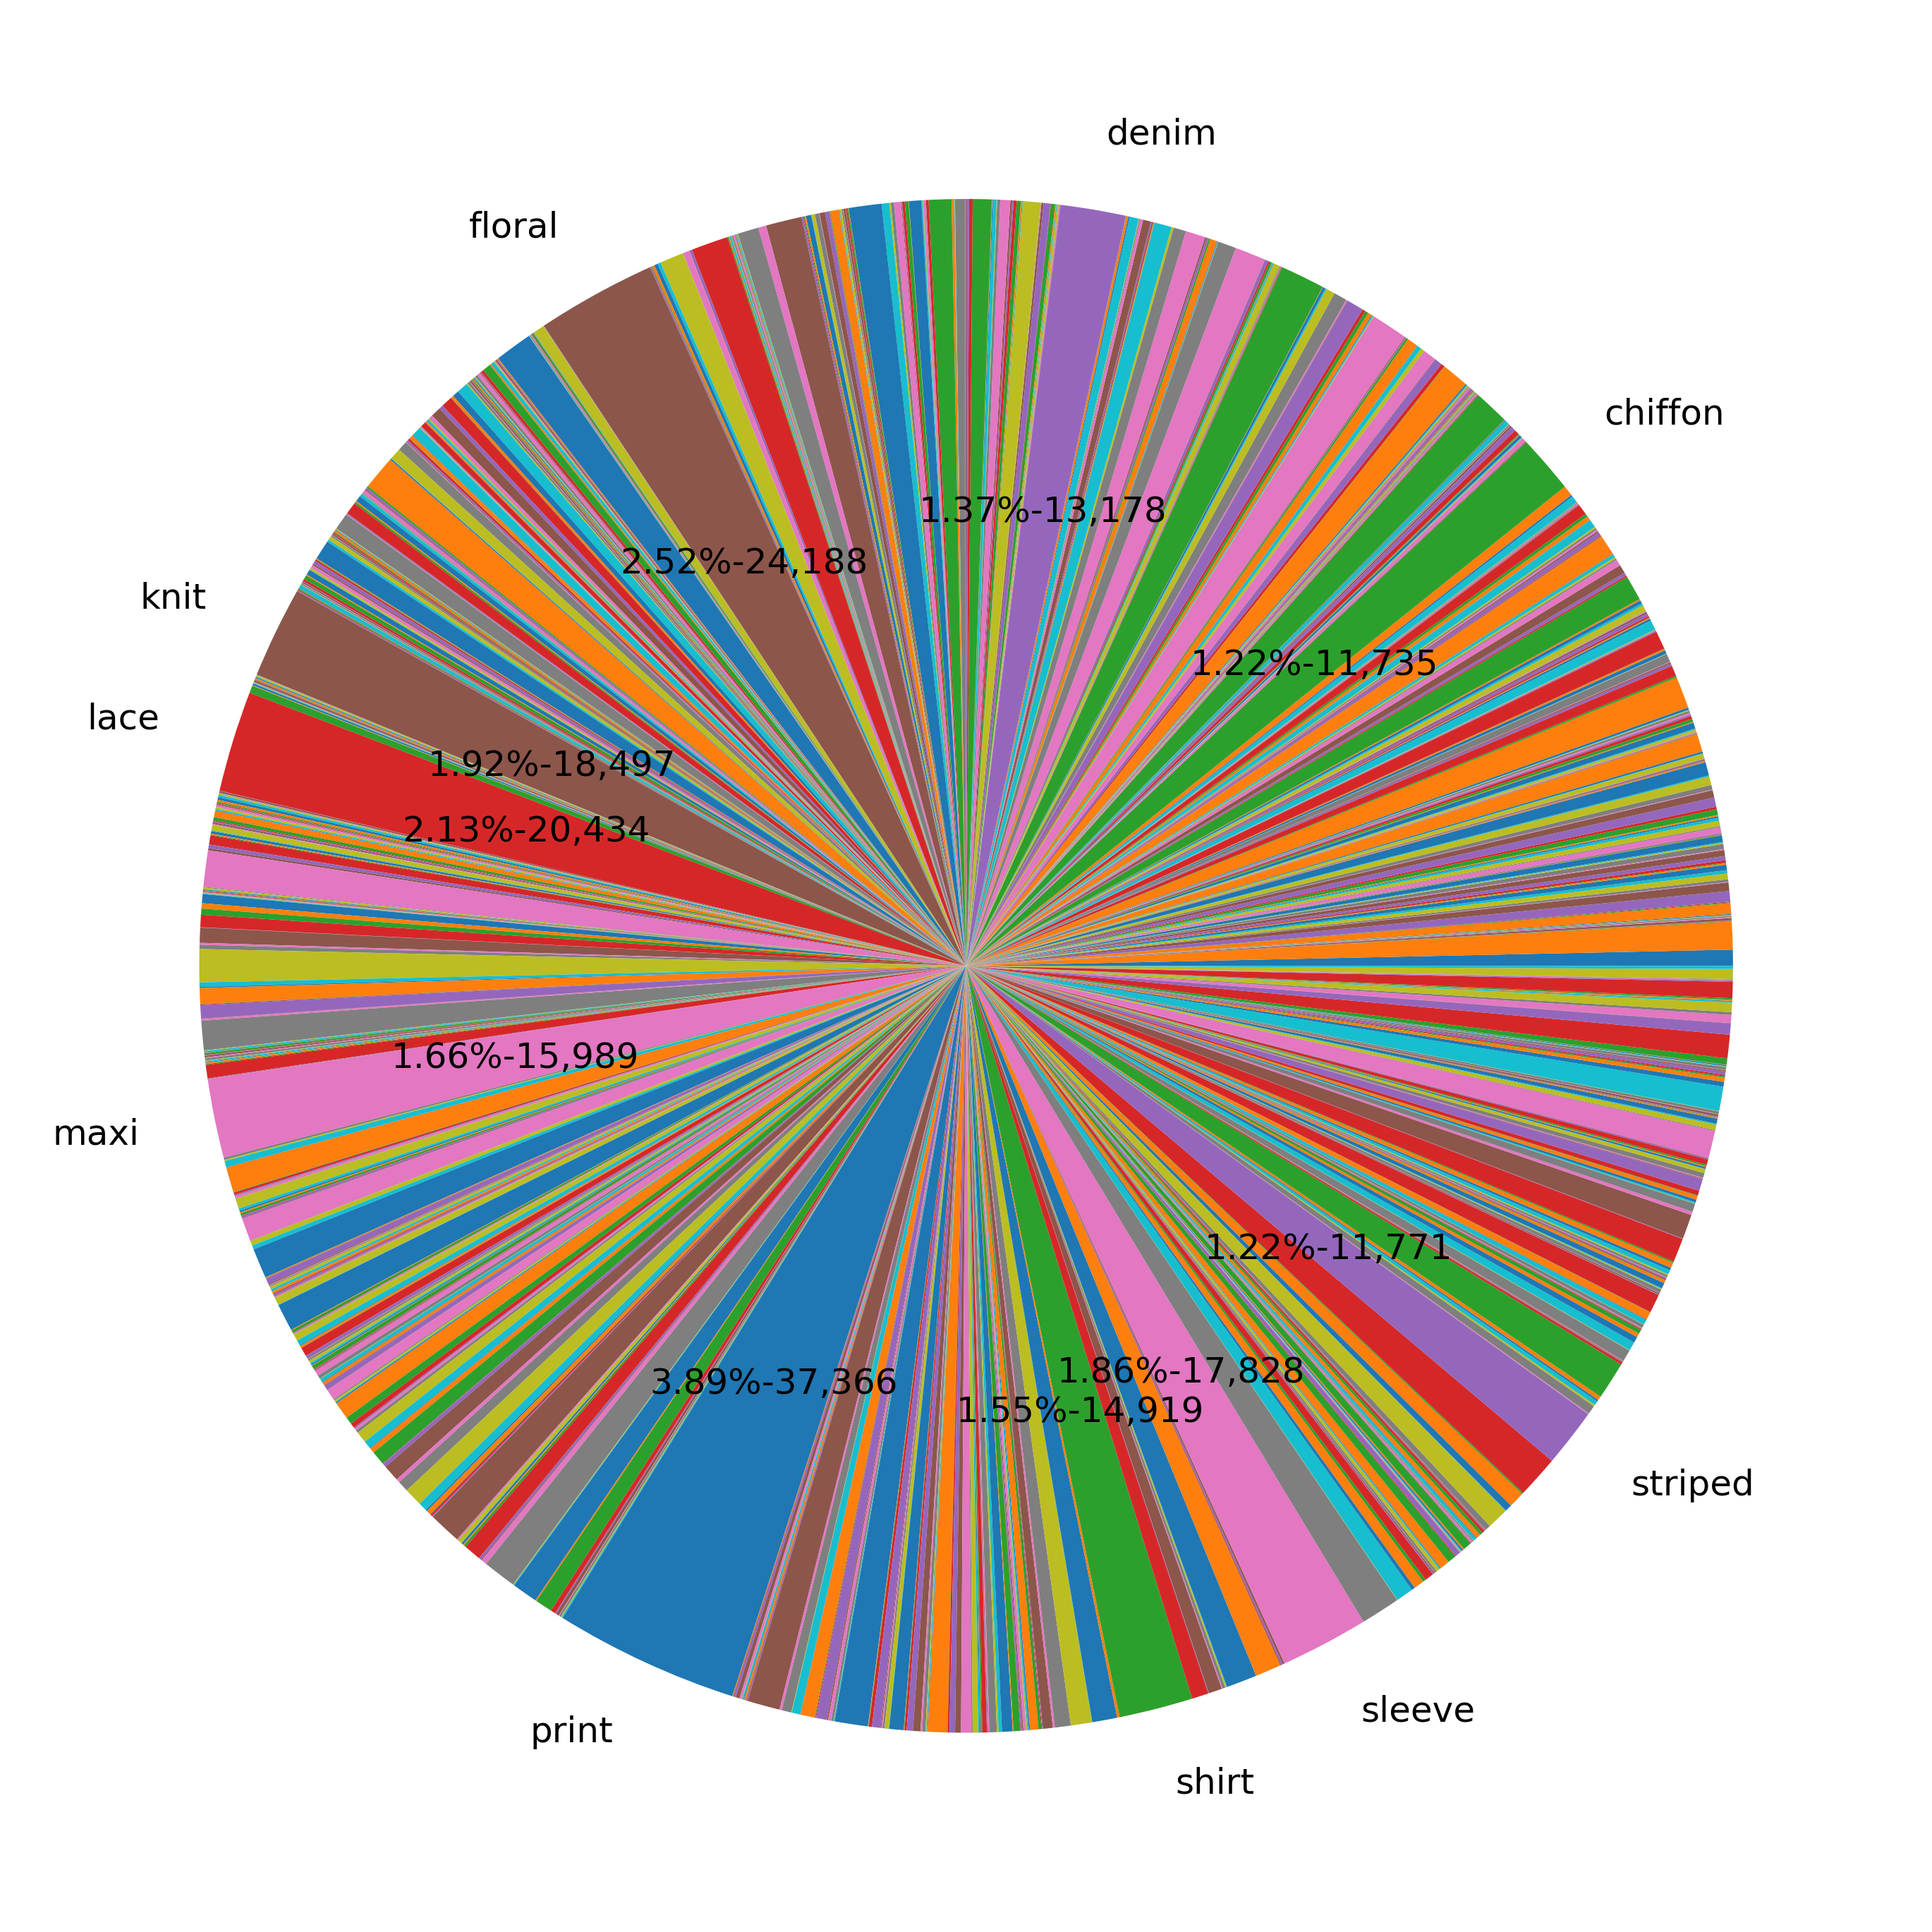

In [52]:
plt.rcParams["figure.figsize"] = [50.0, 50.0]
plt.rcParams['font.size'] = 50.0
plt.pie(attr_dist, labels=make_labels(attr_dist, attr, 1), autopct=make_autopct(attr_dist, 1))
plt.rcParams['font.size'] = def_font
plt.rcParams["figure.figsize"] = def_size

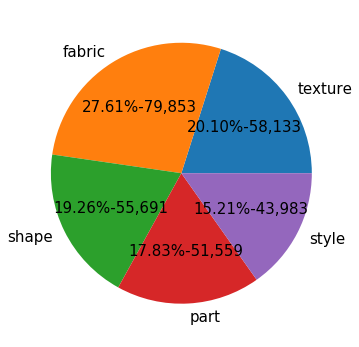

In [53]:
_ = plt.pie(attr_types_dist[1:], labels=attr_types_str.values(), autopct=make_autopct(cat_dist, 2))

Although there is strong imbalance within the distribution of the attributes, the type of attributes appear to be nicely distributed.